# StackGP System in Python
## By: Nathan Haut

### Implementation Notes

This implementation evolves models of the form model = [operator Stack, Variable Constant Stack, ..., [QualityMetrics]].


In [11]:
import random
import matplotlib.pyplot as plt 
import numpy as np
import math
import copy
import sys
from scipy.stats import pearsonr # for computing correlation
from functools import reduce #for flattening lists
from operator import concat  #for flattening lists
from scipy.stats import trim_mean # for ensemble evaluation
import warnings
import time
import dill
import os
from sklearn.cluster import KMeans #for clustering in ensemble definition
from scipy.optimize import minimize #for uncertainty maximization
from sympy import symbols
warnings.filterwarnings('ignore', '.*invalid value.*' )
warnings.filterwarnings('ignore', '.*overflow.*' )
warnings.filterwarnings('ignore', '.*divide by.*' )
warnings.filterwarnings('ignore', '.*is constant.*' )
warnings.filterwarnings('ignore', '.*nearly constant.*' )
warnings.filterwarnings('ignore', '.*Polyfit may be.*' )
warnings.filterwarnings('ignore', '.*Number of.*')
def protectDiv(a,b):
    
    if (type(b)==int or type(b)==float or type(b)==np.float64) and b==0:
        return a/math.nan
    if (type(b)==np.ndarray) and (0 in b):
        return a/np.where(b==0,math.nan,b)
    return a/b
def add(a,b):
    return a+b
def sub(a,b):
    return a-b
def mult(a,b):
    return a*b
def exp(a):
    return np.exp(a)
# def sine(a,b):
#     return np.sin(a)
def power(a,b):
    return a**b
def sqrt(a):
    return np.sqrt(a)
def sqrd(a):
    return a**2
def inv(a):
    return np.array(a).astype(float)**(-1)
def sin(a):
    return np.sin(a)
def cos(a):
    return np.cos(a)
def tan(a):
    return np.tan(a)
def arccos(a):
    return np.arccos(a)
def arcsin(a):
    return np.arcsin(a)
def arctan(a):
    return np.arctan(a)
def tanh(a):
    return np.tanh(a)
def log(a):
    return np.log(a)





def defaultOps():
    return [protectDiv,add,sub,mult,exp,sqrd,sqrt,inv,"pop","pop","pop","pop","pop","pop"]
def allOps():
    return [protectDiv,add,sub,mult,exp,sqrd,sqrt,inv,cos,sin,tan,arccos,arcsin,arctan,tanh,log,"pop","pop","pop","pop","pop","pop","pop","pop","pop","pop"]
def randomInt(a=-3,b=3):
    return random.randint(a,b)
def defaultConst():
    return [np.pi, np.e, randomInt,ranReal ]
def ranReal(a=20,b=-10):
    return random.random()*a-b

In [12]:
import inspect
def getArity(func): #Returns the arity of a function: used for model evaluations
    if func=="pop":
        return 1
    return len(inspect.signature(func).parameters)

getArity.__doc__ = "getArity(func) takes a function and returns the function arity"

def modelArity(model): #Returns the total arity of a model
    return 1+sum([getArity(i)-1 for i in model[0]])

modelArity.__doc__ = "modelArity(model) returns the total arity of a model"

def listArity(data): #Returns arity of evaluating a list of operators
    if len(data)==0:
        return 0
    return 1+sum([getArity(i)-1 for i in data])

listArity.__doc__ = "listArity(list) returns the arity of evaluating a list of operators"

def buildEmptyModel(): # Generates an empty model
    return [[],[],[]]

buildEmptyModel.__doc__ = "buildEmptyModel() takes no inputs and generates an empty GP model"

def variableSelect(num): #Function that creates a function to select a specific variable
    return lambda variables: variables[num]

variableSelect.__doc__ = "variableSelect(n) is a function that creates a function to select the nth variable"


def modelToListForm(model):
    model[0]=model[0].tolist()
def modelRestoreForm(model):
    model[0]=np.array(model[0],dtype=object)


In [13]:
def generateRandomModel(variables,ops,const,maxLength):  #Generates a random GP model
    prog = buildEmptyModel()                             #Generate an empty model with correct structure
    varChoices=[variableSelect(i) for i in range(variables)]+const                           #All variable and constants choices
    prog[0]=np.array(np.random.choice(ops,random.randint(1,maxLength)),dtype=object) #Choose random operators
    countVars=modelArity(prog)    #Count how many variables/constants are needed
    prog[1]=np.random.choice(varChoices,countVars)       #Choose random variables/constants
    prog[1]=[i() if (callable(i) and i.__name__!='<lambda>' )else i for i in prog[1]] #If function then evaluate
    return prog

generateRandomModel.__doc__ = "generateRandomModel() takes as input the variables, operators, constants, and max program length and returns a random program"

def initializeGPModels(variables,ops=defaultOps(),const=defaultConst(),numberOfModels=100,maxLength=10): # generate random linear program
    prog=[[],[],[]]
    # prog stores [Operators, VarConst, QualityMetrics]
    
    models=[generateRandomModel(variables,ops,const,maxLength) for i in range(numberOfModels)] #Generate models
    
    return models

initializeGPModels.__doc__ = "initializeGPModels(countOfVariables, operators, constants, numberOfModels=100, maxLength=10) returns a set of randomly generated models"



In [14]:
def reverseList(data): #Returns a list reversed
    return [i for i in reversed(data)]
reverseList.__doc__ = "reverseList(data) returns the data list reversed"

def varReplace(data,variables): #Replaces variable references with data during model evaluation
    return [i(variables) if callable(i) else i for i in data]
varReplace.__doc__ = "varReplace(data,variables) replaces references to variables in data with actual values"

def inputLen(data): #Returns the number of data records in a data set
    el1=data[0]
    if type(el1)==list or type(el1)==np.ndarray:
        return len(el1)
    else:
        return 1
inputLen.__doc__ = "inputLen(data) determines the number of data records in a data set"

def varCount(data): #Returns the number of variables in a data set
    return len(data)
varCount.__doc__ = "varCount(data) determines the number of variables in a data set"

def evaluateGPModel(model,inputData): #Evaluates a model numerically
    response=evModHelper(model[1],model[0],[],np.array(inputData).astype(float))[2][0]
    if not type(response)==np.ndarray and inputLen(inputData)>1:
        response=np.array([response for i in range(inputLen(inputData))])
    return response
evaluateGPModel.__doc__ = "evaluateGPModel(model,data) numerically evaluates a model using the data stored in inputData"

def evModHelper(varStack,opStack,tempStack,data): #Recursive helper function for evaluateGPModel
    stack1=varStack
    stack2=opStack
    stack3=tempStack
    
    if len(stack2)==0:
        return [stack3,stack2,stack1]
    op=stack2[0]
    stack2=stack2[1:]
    
    if callable(op):
        
        patt=getArity(op)
        while patt>len(stack3):
            stack3=[stack1[0]]+stack3
            stack1=stack1[1:]
        try:
            temp=op(*varReplace(reverseList(stack3[:patt]),data))
        except TypeError:
            print("stack3: ", stack3, " patt: ", patt, " data: ", data)
            temp=np.nan
        except OverflowError:
            temp=np.nan
        stack3=stack3[patt:]
        stack3=[temp]+stack3
        
    else:
        if len(stack1)>0:
            stack3=varReplace([stack1[0]],data)+stack3
            stack1=stack1[1:]
    if len(stack2)>0:
        stack1,stack2,stack3=evModHelper(stack1,stack2,stack3,data)
        
    return [stack1,stack2,stack3]
evModHelper.__doc__ = "evModHelper(varStack,opStack,tempStack,data) is a helper function for evaluateGPModel"



def fitness(prog,data,response): # Fitness function using correlation
    predicted=evaluateGPModel(prog,np.array(data))
    if type(predicted)!=list and type(predicted)!=np.ndarray:
        predicted=np.array([predicted for i in range(inputLen(data))])
    try:    
        if np.isnan(predicted).any() or np.isinf(predicted).any():
            return np.nan
    except TypeError:
        #print(predicted)
        return np.nan
    except OverflowError:
        return np.nan
    if (not all(np.isfinite(np.array(predicted,dtype=np.float32)))) or np.all(predicted==predicted[0]):
        return np.nan
    fit=1-pearsonr(predicted,np.array(response))[0]**2  # 1-R^2
    if math.isnan(fit):
        return 1 # If nan return 1 as fitness
    return fit   # Else return actual fitness 1-R^2

fitness.__doc__ = "fitness(program,data,response) returns the 1-R^2 value of a model"

def stackGPModelComplexity(model,*args):
    return len(model[0])+len(model[1])-model[0].tolist().count("pop")

stackGPModelComplexity.__doc__ = "stackGPModelComplexity(model) returns the complexity of the model"

def setModelQuality(model,inputData,response,modelEvaluationMetrics=[fitness,stackGPModelComplexity]):
    model[2]=[i(model,inputData,response) for i in modelEvaluationMetrics]
    
setModelQuality.__doc__ = "setModelQuality(model, inputdata, response, metrics=[r2,size]) is an inplace operator that sets a models quality"

def stackPass(model,pt):
    i=0
    t=0
    p=0
    s=model[0]
    if i <pt:
        t+=1
    while i<pt:
        if s[i]=="pop":
            t+=1
            p+=1
        else:
            p+=max(0,getArity(s[i])-t)
            t=max(1,t-getArity(s[i])+1)
        i+=1
    stack1=model[1][p:]
    stack2=reverseList(model[1][:p])[:t+1]
    return [stack1,stack2]

def stackGrab(stack1, stack2, num):
    tStack1=copy.deepcopy(stack1)
    tStack2=copy.deepcopy(stack2)
    newStack=[]
    if len(stack2)<num:
        newStack=stack2+stack1[:(num-len(stack2))]
        tStack1=tStack1[num-len(tStack2):]
        tStack2=[]
    else:
        newStack=stack2[:num]
        tStack2=tStack2[num:]
    return [newStack,tStack1,tStack2]

def fragmentVariables(model,pts):
    stack1,stack2=stackPass(model,pts[0])
    opStack=model[0]
    newStack=[]
    i=pts[0]
    while i<=pts[1]:
        if opStack[i]=="pop" and len(stack1)>0:
            stack2=[stack1[0]]+stack2
            stack1=stack1[1:]
        else:
            if len(newStack)==0 and pts[0]==0:
                tStack,stack1,stack2=stackGrab(stack1,stack2,getArity(opStack[i]))
            else:
                tStack,stack1,stack2=stackGrab(stack1,stack2,getArity(opStack[i])-1)
            newStack=newStack+tStack
        i+=1
    return newStack
                                            

def recombination2pt(model1,model2): #2 point recombination
    pts1=np.sort(random.sample(range(0,len(model1[0])+1),2))
    pts2=np.sort(random.sample(range(0,len(model2[0])+1),2))
    #pts1=[4,5]
    #pts2=[2,4]
    #pts1=[0,3]
    #pts2=[1,3]
    #print(pts1,pts2)
    child1=buildEmptyModel()
    child2=buildEmptyModel()
    
    parent1=copy.deepcopy(model1)
    parent2=copy.deepcopy(model2)
    parent1[0]=np.array(parent1[0],dtype=object).tolist()
    parent2[0]=np.array(parent2[0],dtype=object).tolist()
    
    child1[0]=np.array(parent1[0][0:pts1[0]]+parent2[0][pts2[0]:pts2[1]]+parent1[0][pts1[1]:],dtype=object)
    child2[0]=np.array(parent2[0][0:pts2[0]]+parent1[0][pts1[0]:pts1[1]]+parent2[0][pts2[1]:],dtype=object)
        
    varPts1=[listArity(parent1[0][:(pts1[0])])+0,listArity(parent2[0][:(pts2[0])])+0,listArity(parent2[0][pts2[0]:pts2[1]]),listArity(parent1[0][pts1[0]:pts1[1]])]
    if pts1[0]==0:
        varPts1[0]+=1
    if pts2[0]==0:
        varPts1[1]+=1
    child1[1]=parent1[1][:varPts1[0]]+parent2[1][varPts1[1]:(varPts1[1]+varPts1[2]-1)]+parent1[1][(varPts1[0]+varPts1[3]-1):]
    
    varPts2=[listArity(parent2[0][:(pts2[0])])+0,listArity(parent1[0][:(pts1[0])])+0,listArity(parent1[0][pts1[0]:pts1[1]]),listArity(parent2[0][pts2[0]:pts2[1]])]
    if pts1[0]==0:
        varPts2[1]+=1
    if pts2[0]==0:
        varPts2[0]+=1
    child2[1]=parent2[1][:varPts2[0]]+parent1[1][varPts2[1]:(varPts2[1]+varPts2[2]-1)]+parent2[1][(varPts2[0]+varPts2[3]-1):]
    #print(varPts1,varPts2)
    
    return [child1,child2]

recombination2pt.__doc__ = "recombination2pt(model1,model2) does 2 point crossover and returns two children models"

def mutate(model,variables,ops=defaultOps(),const=defaultConst(),maxLength=10):
    newModel=copy.deepcopy(model)
    newModel[0]=newModel[0].tolist()
    mutationType=random.randint(0,6)
    varChoices=[variableSelect(i) for i in range(variables)]+const
    opChoice=0
    varChoice=0
    
    tmp=0
    
    if mutationType==0:
        opChoice=random.randint(0,len(newModel[0])-1)
        if len(newModel[0])>0:
            newModel[0][opChoice]=np.random.choice([i for i in ops] )
               
    elif mutationType==1:
        varChoice=np.random.choice(varChoices)
        if callable(varChoice) and varChoice.__name__!='<lambda>':
            varChoice=varChoice()
        newModel[1][random.randint(0,len(newModel[1])-1)]=varChoice
    
    elif mutationType==2:
        opChoice=np.random.choice(ops)
        newModel[0]=[opChoice]+newModel[0]
        while modelArity(newModel)>len(newModel[1]):
            varChoice=np.random.choice(varChoices)
            if callable(varChoice) and varChoice.__name__!='<lambda>':
                varChoice=varChoice()
            newModel[1]=[varChoice]+newModel[1]
        
    elif mutationType==3:
        if len(newModel[0])>1:
            opChoice=random.randint(1,len(newModel[0])-1)
            newModel[0]=newModel[0][-opChoice:]
            newModel[1]=newModel[1][-listArity(newModel[0]):]
            
    elif mutationType==4:
        opChoice=np.random.choice([i for i in ops])
        newModel[0].append(opChoice)
        
    elif mutationType==5:
        newModel=recombination2pt(newModel,generateRandomModel(variables,ops,const,maxLength))[0]
            
    elif mutationType==6: #single operator insertion mutation
        singleOps=[op for op in ops if getArity(op)==1 and op!='pop']
        singleOps.append('pop')
        pos=random.randint(0,len(newModel[0])-1)
        newModel[0].insert(pos,np.random.choice(singleOps))
    
    if modelArity(newModel)<len(newModel[1]):
        newModel[1]=newModel[1][:modelArity(newModel)]
    elif modelArity(newModel)>len(newModel[1]):
        newModel[1]=newModel[1]+[np.random.choice(varChoices) for i in range(modelArity(newModel)-len(newModel[1]))]
    newModel[1]=[varChoice() if callable(varChoice) and varChoice.__name__!='<lambda>' else varChoice for varChoice in newModel[1]]         
    newModel[0]=np.array(newModel[0],dtype=object)
    return newModel
    
mutate.__doc__ = "mutate(model,variableCount,ops,constants,maxLength) mutates a model"

def paretoFront(fitValues): #Returns Boolean list of Pareto front elements
    onFront = np.ones(fitValues.shape[0], dtype = bool)
    for i, j in enumerate(fitValues):
        if onFront[i]:
            onFront[onFront] = np.any(fitValues[onFront]<j, axis=1)  
            onFront[i] = True  
    return onFront
def paretoTournament(pop): # selects the Pareto front of a model set
    fitnessValues=np.array([mod[2] for mod in pop])
    return (np.array(pop,dtype=object)[paretoFront(fitnessValues)]).tolist()

def tournamentModelSelection(models, popSize=100,tourneySize=5):
    selectedModels=[]
    selectionSize=popSize
    while len(selectedModels)<popSize:
        tournament=random.sample(models,tourneySize)
        winners=paretoTournament(tournament)
        selectedModels=selectedModels+winners
    
    return selectedModels

paretoTournament.__doc__ = "paretoTournament(models, inputData, responseData) returns the Pareto front of a model set"

def modelSameQ(model1,model2): #Checks if two models are the same
    return len(model1[0])==len(model2[0]) and len(model1[1]) == len(model2[1]) and all(model1[0]==model2[0]) and model1[1]==model2[1]

modelSameQ.__doc__ = "modelSameQ(model1,model2) checks if model1 and model2 are the same and returns True if so, else False"


def deleteDuplicateModels(models): #Removes any models that are the same, does not consider simplified form
    uniqueMods = [models[0]]
     
    for mod in models:
        test=False
        for checkMod in uniqueMods:
            if modelSameQ(mod,checkMod):
                test=True
        if not test:
            uniqueMods.append(mod)
    
    return uniqueMods

deleteDuplicateModels.__doc__ = "deleteDuplicateModels(models) deletes models that have the same form without simplifying"

def removeIndeterminateModels(models): #Removes models from the population that evaluate to nonreal values
    return [i for i in models if (not any(np.isnan(i[2]))) and all(np.isfinite(np.isnan(i[2])))]

removeIndeterminateModels.__doc__ = "removeIndeterminateModels(models) removes models that have a fitness that results from inf or nan values"

def sortModels(models):
    return sorted(models, key=lambda m:m[2])

sortModels.__doc__ = "sortModels(models) sorts a model population by the models' accuracies"

def selectModels(models, selectionSize=0.5):
    tMods=copy.deepcopy(models)
    [modelToListForm(mod) for mod in tMods]
    paretoModels=[]
    if selectionSize<=1:
        selection=selectionSize*len(models)
    else:
        selection=selectionSize
    
    while len(paretoModels)<selection:
        front=paretoTournament(tMods)
        paretoModels=paretoModels+front
        for i in front:
            tMods.remove(i)
    [modelRestoreForm(mod) for mod in paretoModels]
    return paretoModels

selectModels.__doc__ = "selectModels(models, selectionSize=0.5) iteratively selects the Pareto front of a model population until n or n*popSize models are selected"

def stackVarUsage(opStack): #Counts how many variables are used by the operator stack
    pos=getArity(opStack[0])
    for j in range(1,len(opStack)):
        pos+=getArity(opStack[j])-1
        if opStack[j]=='pop':
            pos+=1
    return pos

stackVarUsage.__doc__ = "stackVarUsage(opStack) is a helper function that determines how many variables/constants are needed by the operator stack"

def trimModel(mod): #Removes extra pop operators that do nothing
    model=copy.deepcopy(mod)
    i=0
    varStack=len(mod[1])
    tempStack=0
    varStack-=getArity(model[0][i])
    tempStack+=1
    i+=1
    while varStack>0:
        if model[0][i]=='pop':
            varStack-=1
            tempStack+=1
        else:
            
            take=getArity(model[0][i])-tempStack
            if take>0:
                varStack-=take
                tempStack=1
            else:
                tempStack-=getArity(model[0][i])-1
        i+=1
    model[0]=np.array(model[0][:i].tolist()+[j for j in model[0][i:] if not j=='pop'],dtype=object)
    return model

trimModel.__doc__ = "trimModel(model) trims extra pop operators off the operator stack so that further modifications such as a model alignment aren't altered by those pop operators"


def alignGPModel(model, data, response): #Aligns a model
    prediction=evaluateGPModel(model,data)
    if (not all(np.isfinite(np.array(prediction)))) or np.all(prediction==prediction[0]):
        return model
    if np.isnan(np.array(prediction)).any() or np.isnan(np.array(response)).any() or not np.isfinite(np.array(prediction,dtype=np.float32)).all():
        return model
    try:
        align=np.round(np.polyfit(prediction,response,1,rcond=1e-16),decimals=14)
    except np.linalg.LinAlgError:
        #print("Alignment failed for: ", model, " with prediction: ", prediction, "and reference data: ", response)
        return model
    newModel=trimModel(model)
    newModel[0]=np.array(newModel[0].tolist()+[mult,add],dtype=object)
    newModel[1]=newModel[1]+align.tolist()
    setModelQuality(newModel,data,response)
    return newModel

alignGPModel.__doc__ = "alignGPModel(model, input, response) aligns a model such that response-a*f(x)+b are minimized over a and b"


def evolve(inputData, responseData, generations=100, ops=defaultOps(), const=defaultConst(), variableNames=[], mutationRate=79, crossoverRate=11, spawnRate=10, extinction=False,extinctionRate=10,elitismRate=50,popSize=300,maxComplexity=100,align=True,initialPop=[],timeLimit=300,capTime=False,tourneySize=5,tracking=False):
    
    fullInput,fullResponse=copy.deepcopy(inputData),copy.deepcopy(responseData)
    inData=copy.deepcopy(fullInput)
    resData=copy.deepcopy(fullResponse)
    variableCount=varCount(inData)
    models=initializeGPModels(variableCount,ops,const,popSize)
    models=models+initialPop
    startTime=time.perf_counter()
    bestFits=[]
    for i in range(generations):
        if capTime and time.perf_counter()-startTime>timeLimit:
            break
        for mods in models:
            setModelQuality(mods,inData,resData)
        
        if tracking:
            bestFits.append(min([mods[2][0] for mods in paretoTournament(models)])) 
       
        #paretoModels=paretoTournament(models)
        paretoModels=selectModels(models,elitismRate/100*popSize)
        if extinction and i%extinctionRate:
            models=initializeGPModels(variableCount,ops,const,popSize)
            for mods in models:
                setModelQuality(mods,inData,resData)
        
        models=tournamentModelSelection(models,popSize,tourneySize)
        
        crossoverPairs=random.sample(models,round(crossoverRate/100*popSize))
        toMutate=random.sample(models,round(mutationRate/100*popSize))
        
        childModels=paretoModels
        
        for j in range(round(len(crossoverPairs)/2)-1):
            childModels=childModels+recombination2pt(crossoverPairs[j],crossoverPairs[j+round(len(crossoverPairs)/2)])
        
        for j in toMutate:
            childModels=childModels+[mutate(j,variableCount,ops,const)]
        
        childModels=childModels+initializeGPModels(variableCount,ops,const,round(spawnRate/100*popSize))
        
        childModels=deleteDuplicateModels(childModels)
        
        for mods in childModels:
            setModelQuality(mods,inData,resData)
        childModels=removeIndeterminateModels(childModels)
        
        if len(childModels)<popSize:
            childModels=childModels+initializeGPModels(variableCount,ops,const,popSize-len(childModels))
        
        models=copy.deepcopy(childModels)
        
    
    for mods in models:
        setModelQuality(mods,fullInput,fullResponse)

    models=[trimModel(mod) for mod in models]
    models=deleteDuplicateModels(models)
    models=removeIndeterminateModels(models)

    models=sortModels(models)
    if align:
        models=[alignGPModel(mods,fullInput,fullResponse) for mods in models]
    
    if tracking:
        bestFits.append(min([mods[2][0] for mods in paretoTournament(models)])) 
        plt.figure()
        plt.plot(bestFits)
        plt.title("Fitness over Time")
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
    
    return models
    

In [15]:
def replaceFunc(stack,f1,f2):
    return [i if i!=f1 else f2 for i in stack]
def printGPModel(mod,inputData=symbols(["x"+str(i) for i in range(100)])): #Evaluates a model numerically
    def inv1(a):
        return a**(-1)
    from sympy import tan as tan1, exp as exp1, sqrt as sqrt1, sin as sin1, cos as cos1, acos, asin, atan, tanh as tanh1, log as log1
    def sqrt2(a):
        return sqrt1(a)
    def log2(a):
        return log1(a)
    model = copy.deepcopy(mod)
    model[0] = replaceFunc(model[0],exp,exp1)
    model[0] = replaceFunc(model[0],tan,tan1)
    model[0] = replaceFunc(model[0],sqrt,sqrt2)
    model[0] = replaceFunc(model[0],inv,inv1)
    model[0] = replaceFunc(model[0],sin,sin1)
    model[0] = replaceFunc(model[0],cos,cos1)
    model[0] = replaceFunc(model[0],arccos,acos)
    model[0] = replaceFunc(model[0],arcsin,asin)
    model[0] = replaceFunc(model[0],arctan,atan)
    model[0] = replaceFunc(model[0],tanh,tanh1)
    model[0] = replaceFunc(model[0],log,log2)
    response=evModHelper(model[1],model[0],[],np.array(inputData))[2][0]
    return response

In [16]:
def ensembleSelect(models, inputData, responseData, numberOfClusters=10): #Generates a model ensemble using input data partitions
    data=np.transpose(inputData)
    if len(data)<numberOfClusters:
        numberOfClusters=len(data)
    clusters=KMeans(n_clusters=numberOfClusters).fit_predict(data)
    if numberOfClusters>len(set(clusters)):
        numberOfClusters=len(set(clusters))
        clusters=KMeans(n_clusters=numberOfClusters).fit_predict(data)
    dataParts=[]
    partsResponse=[]
    for i in range(numberOfClusters):
        dataParts.append([])
        partsResponse.append([])
    
    for i in range(len(clusters)):
        dataParts[clusters[i]].append(data[i])
        partsResponse[clusters[i]].append(responseData[i])
        
    modelResiduals=[]
    
    for i in range(len(models)):
        modelResiduals.append([])
    for i in range(len(models)):
        for j in range(numberOfClusters):
            modelResiduals[i].append(fitness(models[i],np.transpose(dataParts[j]),partsResponse[j]))
    
    best=[]
    for i in range(numberOfClusters):
        ordering=np.argsort(modelResiduals[i])
        j=0
        while ordering[j] in best:
            j+=1
        best.append(ordering[j])

    ensemble=[models[best[i]] for i in range(numberOfClusters)]

    
    return ensemble

def uncertainty(data,trim=0.3):
    sortData=np.sort(data)
    trim=round(trim*len(data)/2)
    if trim==0:
        return np.std(data)
    return np.std(data[trim:-trim])
    

def evaluateModelEnsemble(ensemble, inputData):
    responses=[evaluateGPModel(mod, inputData) for mod in ensemble]
    if type(responses[0])==np.ndarray:
        responses=np.transpose(responses)
        uncertainties=[uncertainty(res,0.3) for res in responses]
        responses=[trim_mean(res,0.3) for res in responses]
    else:
        
        uncertainties=[uncertainty(responses,0.3)]
        responses=[trim_mean(responses,0.3)]
    
    return responses,uncertainties

def relativeEnsembleUncertainty(ensemble,inputData):
    output=evaluateModelEnsemble(ensemble,inputData)
    return np.array(output[1])/abs(np.array(output[0]))
    
def createUncertaintyFunc(ensemble):
    return lambda x: -relativeEnsembleUncertainty(ensemble,x)
    
def maximizeUncertainty(ensemble,varCount,bounds=[]): #Used to select a new point of maximum uncertainty
    func=createUncertaintyFunc(ensemble)
    x0=[1 for i in range(varCount)]
    if bounds==[]:
        pt=minimize(func,x0).x
    else:
        pt=minimize(func,x0,bounds=bounds).x
    return pt

def extendData(data,newPoint):
    return np.concatenate((data.T,np.array([newPoint]))).T


In [17]:
def activeLearningCheckpoint(eqNum,version,i,inputData,response,testInput,testResponse,errors,models,minerr):
    path=os.path.join(str(eqNum),str(version))
    file=open(path,"wb+")
    dill.dump([i,inputData,response,testInput,testResponse,errors,models,minerr],file)
    file.close()

def activeLearningCheckpointLoad(eqNum,version,i,inputData,response,testInput,testResponse,errors,models,minerr):
    path=os.path.join(str(eqNum),str(version))
    try:
        with open(path,'rb') as f:
            i,inputData,response,testInput,testResponse,errors,models,minerr=dill.load(f)
    except FileNotFoundError:
        return i,inputData,response,testInput,testResponse,errors,models,minerr
    return i,inputData,response,testInput,testResponse,errors,models,minerr

def subSampleSpace(space):
    newSpace=copy.deepcopy(space)
    newSpace=list(newSpace)
    for i in range(len(newSpace)):
        pts=sorted([np.random.uniform(newSpace[i][0],newSpace[i][1]),np.random.uniform(newSpace[i][0],newSpace[i][1])])
        newSpace[i]=tuple(pts)
    return tuple(newSpace)

In [44]:
def activeLearning(func, dims, ranges,rangesP,eqNum=1,version=1,iterations=100): #func should be a lamda function of form lambda data: f(data[0],data[1],...)
    inputData=[]
    testInput=[]
    for i in range(dims):
        inputData.append(np.random.uniform(ranges[i][0],ranges[i][1],3))
        testInput.append(np.random.uniform(ranges[i][0],ranges[i][1],200))
    inputData=np.array(inputData)
    testInput=np.array(testInput)
    response=func(inputData)
    testResponse=func(testInput)
    errors=[]
    models=[]
    minerr=1
    for i in range(iterations):
        print("input: ",inputData)
        print("\n response: ",response)
        activeLearningCheckpointLoad(eqNum,version,i,inputData,response,testInput,testResponse,errors,models,minerr)
            
        models1=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models2=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models3=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models4=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models=models1+models2+models3+models4
        models=selectModels(models,20)
        alignedModels=[alignGPModel(mods,inputData,response) for mods in models]
        ensemble=ensembleSelect(alignedModels,inputData,response)
        out=maximizeUncertainty(ensemble,dims,rangesP)
        while out in inputData.T:
            out=maximizeUncertainty(ensemble,dims,subSampleSpace(rangesP))
        inputData=extendData(inputData,out)
        response=func(inputData)
        errors.append(min([fitness(mod, testInput,testResponse) for mod in alignedModels]))
        minerr=errors[-1]
        if minerr<1e-14:
            #print("Points needed in round", j,": ",3+i, " Time needed: ", time.perf_counter()-roundTime)
            if not os.path.exists(str(eqNum)):
                os.makedirs(str(eqNum))
            path=os.path.join(str(eqNum),str(version))
            file=open(path,"wb+")
            dill.dump([i,inputData,response,testInput,testResponse,errors,models,minerr],file)
            file.close()
            file=open(path+'.txt','w+')
            file.write(str(i+3)+'\n')
            file.write(str(errors))
            file.close()
            return 3+i
            found=True
            ptsNeeded.append(3+i)
            break
        activeLearningCheckpoint(eqNum,version,i,inputData,response,testInput,testResponse,errors,models,minerr)
    if found==False:
        #print("Points needed in round",j,": NA (model not found)")
        path=os.path.join(str(eqNum),str(version))
        file=open(path,"wb")
        dill.dump([-1,inputData,response,testInput,testResponse,errors,models,minerr],file)
        file.close()
        file=open(path+'.txt',"w+")
        file.write(str(i+3))
        file.write(str(errors))
        file.close()
        return -1

In [43]:
[1,3,4] in [[1,3,4],[1,2,2]]

True

In [ ]:
activeLearning(lambda data: (np.exp(-(((data[0]-data[1])/data[2])**2)/2)/(sqrt(2*np.pi)*data[2])),3,[[1,3],[1,3],[1,3]],((1,3),(1,3),(1,3)),eqNum=3,version=1,iterations=10)

input:  [[1.30252048 1.33683214 2.02464289]
 [1.06906015 1.58595264 1.22569942]
 [1.91936259 1.69762538 1.6801953 ]]

 response:  [0.20631954 0.23248345 0.21205668]


In [39]:
space=((1,3),(1,3),(1,3))
space=list(space)
new=(np.random.uniform(space[0][0],space[0][1]),np.random.uniform(space[0][0],space[0][1]))
new
new=sorted(new)
new
space[0]=(new[0],new[1])
space=tuple(space)
space

((2.5301477333407623, 2.728418202384151), (1, 3), (1, 3))

In [42]:

subSampleSpace(((1,3),(1,3),(1,3)))

((1.3206913946691197, 1.8132138092608878),
 (1.3018127602990994, 1.7481037517507034),
 (2.4413436761418232, 2.9292572651215494))

In [42]:
ptsNeeded=[]
start=time.perf_counter()
for j in range(100):
    found=False
    inputData=np.array([np.random.uniform(1,2,3),np.random.uniform(2,5,3),np.random.uniform(1,5,3)])
    response=np.arcsin(inputData[0]/(inputData[1]*inputData[2]))
    testInput=np.array([np.random.uniform(1,2,200),np.random.uniform(2,5,200),np.random.uniform(1,5,200)])
    testResponse=np.arcsin(testInput[0]/(testInput[1]*testInput[2]))
    errors=[]
    models=[]
    roundTime=time.perf_counter()
    for i in range(100):
        models1=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models2=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models3=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models4=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models=models1+models2+models3+models4
        models=sortModels(models)[:100]+paretoTournament(models)
        alignedModels=[alignGPModel(mods,inputData,response) for mods in models]
        ensemble=ensembleSelect(alignedModels,inputData,response)
        out=maximizeUncertainty(ensemble,3,((1,2),(2,5),(1,5)))
        inputData=extendData(inputData,out)
        response=np.arcsin(inputData[0]/(inputData[1]*inputData[2]))
        errors.append(min([fitness(mod, testInput,testResponse) for mod in alignedModels]))
        minerr=errors[-1]
        if minerr<1e-14:
            print("Points needed in round", j,": ",3+i, " Time needed: ", time.perf_counter()-roundTime)
            found=True
            ptsNeeded.append(3+i)
            break
    if found==False:
        print("Points needed in round",j,": NA (model not found)")
stop=time.perf_counter()-start
print("Time: ",stop)

Points needed in round 0 :  3  Time needed:  373.80267229201854
Points needed in round 1 :  4  Time needed:  758.9035540419864
Points needed in round 2 :  4  Time needed:  750.6328847499972
Points needed in round 3 :  3  Time needed:  372.9139214169991
Points needed in round 4 :  3  Time needed:  371.2244557920203
Points needed in round 5 :  4  Time needed:  743.936077499995
Points needed in round 6 :  3  Time needed:  370.8234157920233
Points needed in round 7 :  3  Time needed:  368.92875358398305
Points needed in round 8 :  3  Time needed:  370.01724183297483
Points needed in round 9 :  5  Time needed:  1119.9209554590052
Points needed in round 10 :  3  Time needed:  373.6143811669899
Points needed in round 11 :  4  Time needed:  755.115173541999
Points needed in round 12 :  3  Time needed:  376.6653729159734
Points needed in round 13 :  3  Time needed:  371.4537324590201
Points needed in round 14 :  4  Time needed:  758.9077585420164
Points needed in round 15 :  3  Time needed:  37

In [19]:
tan(*[0])

0.0

In [ ]:
ptsNeeded=[]
start=time.perf_counter()
for j in range(100):
    found=False
    inputData=np.array([np.random.uniform(1,3,3),np.random.uniform(1,3,3),np.random.uniform(1,3,3),np.random.uniform(1,3,3)])
    response=1/4*inputData[0]*(inputData[1]**2*inputData[2]**2)*inputData[3]**2
    testInput=np.array([np.random.uniform(1,3,200),np.random.uniform(1,3,200),np.random.uniform(1,3,200),np.random.uniform(1,3,200)])
    testResponse=1/4*testInput[0]*(testInput[1]**2*testInput[2]**2)*testInput[3]**2
    errors=[]
    models=[]
    roundTime=time.perf_counter()
    for i in range(100):
        models1=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models2=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models3=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models4=evolve(inputData,response,initialPop=models,generations=1000,tracking=False,popSize=300,ops=allOps(),timeLimit=120,capTime=True,align=False,elitismRate=10)
        models=models1+models2+models3+models4
        models=sortModels(models)[:100]+paretoTournament(models)
        alignedModels=[alignGPModel(mods,inputData,response) for mods in models]
        ensemble=ensembleSelect(alignedModels,inputData,response)
        out=maximizeUncertainty(ensemble,4,((1,3),(1,3),(1,3),(1,3)))
        inputData=extendData(inputData,out)
        response=1/4*inputData[0]*(inputData[1]**2*inputData[2]**2)*inputData[3]**2
        errors.append(min([fitness(mod, testInput,testResponse) for mod in alignedModels]))
        minerr=errors[-1]
        if minerr<1e-14:
            print("Points needed in round", j,": ",3+i, " Time needed: ", time.perf_counter()-roundTime)
            found=True
            ptsNeeded.append(3+i)
            break
    if found==False:
        print("Points needed in round",j,": NA (model not found)")
stop=time.perf_counter()-start
print("Time: ",stop)
print("Last Model: ", sortModels(models)[0])

In [105]:
tMods=copy.deepcopy(models)
[modelToListForm(mod) for mod in tMods]
paretoModels=[]
selection=10


In [106]:

front=paretoTournament(tMods)
paretoModels=paretoModels+front
for i in front:
    tMods.remove(i)
paretoModels=[modelRestoreForm(mod) for mod in paretoModels]

In [110]:
len(selectModels(models1,selectionSize=10))

10

In [89]:
models[0][0]=np.array(models[0][0])

In [70]:
models[1]

[array([<function add at 0x7fb40abce1f0>, 'pop',
        <function sqrd at 0x7fb3b817c9d0>,
        <function mult at 0x7fb3b817c790>, 'pop',
        <function sqrt at 0x7fb3b817c940>, 'pop',
        <function exp at 0x7fb3b817c820>,
        <function protectDiv at 0x7fb3e8405280>,
        <function sub at 0x7fb3b8170af0>], dtype=object),
 [<function __main__.variableSelect.<locals>.<lambda>(variables)>,
  <function __main__.variableSelect.<locals>.<lambda>(variables)>,
  <function __main__.variableSelect.<locals>.<lambda>(variables)>,
  <function __main__.variableSelect.<locals>.<lambda>(variables)>,
  <function __main__.variableSelect.<locals>.<lambda>(variables)>],
 [2.267245230636039e-05, 12]]

In [ ]:
    tMods=copy.deepcopy(models)
    paretoModels=[]
    if selectionSize<=1:
        selection=selectionSize*len(models)
    else:
        selection=selectionSize
    
    while len(paretoModels)<selection:
        front=paretoTournament(models)
        paretoModels=paretoModels+front
        for i in front:
            models.remove(i)

In [42]:
testList=[[[1,2,4]],[1,2]]
testList.remove([[1,2,4]])
testList

[[1, 2]]

In [ ]:
errors

In [43]:
np.median(ptsNeeded)

3.0

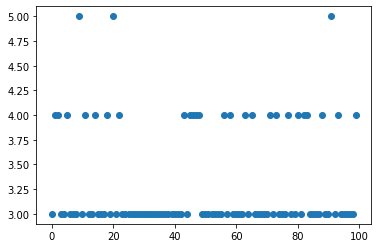

In [44]:
plt.scatter(range(len(ptsNeeded)),ptsNeeded)

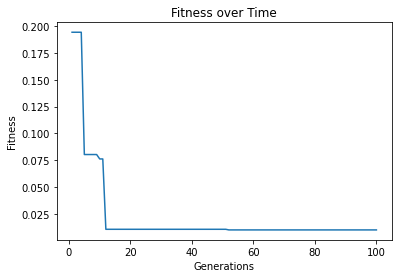

In [12]:
models=evolve(inputData,response,initialPop=models,tracking=True)

In [371]:
ensemble=ensembleSelect(models,inputData,response)

In [372]:
out=maximizeUncertainty(ensemble,3,((1,2),(2,5),(1,5)))
out

array([1., 2., 1.])

In [373]:
relativeEnsembleUncertainty(ensemble,out)

array([0.05477329])

In [374]:
inputData=extendData(inputData,out)
response=np.arcsin(inputData[0]/(inputData[1]*inputData[2]))
response

array([0.24930494, 0.23641433, 0.38243752, 0.52359878, 0.52359878,
       0.52359878, 1.57079633, 0.34499334, 0.52359878, 0.35609187,
       0.60465804, 0.52359878, 0.54293695, 0.10016742, 0.52359878,
       0.10016742, 0.44876586, 0.69388876, 0.10016742, 0.20135792,
       0.34506838, 0.52359878])

In [26]:
response

array([0.28213098, 0.46138993, 0.20322023, 0.52359878, 0.69733875,
       0.39062407, 0.20135792, 0.38966733, 0.39507108, 0.20135792,
       0.38438965, 1.57079633, 0.20135792, 0.43038835, 0.78307103,
       0.53943961, 0.41151685, 0.20135792, 0.6391146 , 0.52359878,
       0.68277321, 0.04001067, 0.50659267, 0.20135792, 0.52359878,
       0.20135792, 0.60134294, 0.20135792, 0.20135792, 0.43895632,
       0.38764135, 0.20135792, 0.48423477, 0.82551345, 0.45067295,
       0.20135792, 0.20135792, 0.20135792, 0.52703439, 0.56569178,
       0.53808432, 0.54535134, 0.53636632, 0.20135792, 0.20135792,
       0.33758907, 0.42090133, 0.42169816, 0.4477996 , 0.49186213,
       0.20135792, 0.37794335, 0.46368426, 0.48741067, 0.20135792,
       0.42995711, 0.43326109, 0.50160016, 0.47639691, 0.55574343,
       0.47321996, 0.44172146, 0.49378238, 0.59012584, 0.04001067,
       0.67559582, 0.6342955 , 0.52359878, 0.47624242, 0.52359878,
       0.04001067, 0.5673702 , 0.52073037, 0.43766584, 0.33818

In [375]:
errors.append(min([fitness(mod, testInput,testResponse) for mod in models]))

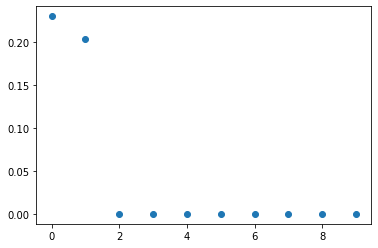

In [22]:
plt.scatter(range(len(errors)),errors)

In [23]:
np.min(errors)

2.220446049250313e-16

In [37]:
responses=[evaluateGPModel(mod, testInput) for mod in ensemble]

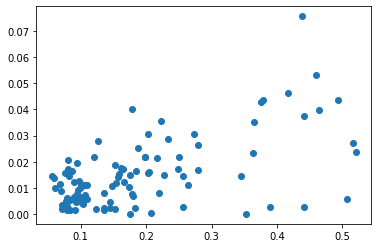

In [87]:
plt.scatter(evaluateModelEnsemble(ensemble,testInput)[0],evaluateModelEnsemble(ensemble,testInput)[1])

In [9]:
testInput=np.array([np.random.uniform(1,2,100),np.random.uniform(2,5,100),np.random.uniform(1,5,100)])
testResponse=np.arcsin(testInput[0]/(testInput[1]*testInput[2]))
KMeans(n_clusters=3).fit_predict(np.transpose(testInput))

array([0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2,
       1, 2, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0, 0,
       1, 2, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 2, 1, 0, 1, 2, 0, 1, 2, 2, 1,
       0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 1, 1, 0, 0, 2,
       0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 1, 0], dtype=int32)

In [15]:
inputData=np.array([np.random.uniform(1,3,3)])
response=np.exp(-(inputData[0]**2)/2)/np.sqrt(2*np.pi)

In [14]:
testInput=np.array([np.random.uniform(1,3,3)])
testResponse=np.exp(-(inputData[0]**2)/2)/np.sqrt(2*np.pi)

NameError: name 'inputData' is not defined

In [599]:
randomMods[10]

[array([<function arccos at 0x7fa3f098a3a0>,
        <function sub at 0x7fa3f098a430>, <function sub at 0x7fa3f098a430>,
        'pop', <function sin at 0x7fa3f098a790>,
        <function exp at 0x7fa3f098a9d0>], dtype=object),
 [2.718281828459045, 3.141592653589793, 3],
 []]

In [600]:
randomMods=initializeGPModels(3,ops=allOps())

120.29486166709103


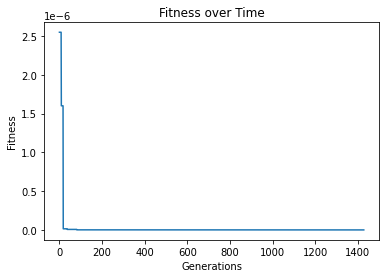

In [620]:
begin=time.perf_counter()
evolvedMods=evolve(inputData,response,popSize=300,tracking=True,ops=allOps(),capTime=True,timeLimit=120,generations=100000)
print(time.perf_counter()-begin)

In [622]:
np.sqrt(np.mean(np.abs(evaluateGPModel(paretoTournament(evolvedMods)[0],testInput)-testResponse)**2))

0.1623108282614847

In [607]:
paretoTournament(evolvedMods)[0]

[array(['pop', 'pop', <function add at 0x7fa3f098a160>,
        <function sin at 0x7fa3f098a790>, <function exp at 0x7fa3f098a9d0>,
        'pop', <function sub at 0x7fa3f098a430>,
        <function cos at 0x7fa3f098adc0>,
        <function mult at 0x7fa3f098a280>,
        <function mult at 0x7fa3f098a280>,
        <function add at 0x7fa3f098a160>], dtype=object),
 [<function __main__.variableSelect.<locals>.<lambda>(variables)>,
  -2,
  12.538640202104032,
  <function __main__.variableSelect.<locals>.<lambda>(variables)>,
  1.2217735706095523,
  -1.7307847566895709],
 [0.000310597503500154, 14]]

In [608]:
[i[2] for i in paretoTournament(evolvedMods)]

[[0.000310597503500154, 14],
 [0.0006426945113916505, 12],
 [0.0007531381141679949, 11],
 [0.0027844386624548134, 10],
 [0.0034518314136208206, 9],
 [0.023660027565680752, 8],
 [0.04832608311755926, 7],
 [0.09060939754432895, 6],
 [0.2975714360125694, 5],
 [1, 1]]

## Testing

In [ ]:
errors=[]
for i in range(100):
    inputData=np.array([np.random.uniform(1,2,3),np.random.uniform(2,5,3),np.random.uniform(1,5,3)])
    response=np.arcsin(inputData[0]/(inputData[1]*inputData[2]))
    testInput=np.array([np.random.uniform(1,2,200),np.random.uniform(2,5,200),np.random.uniform(1,5,200)])
    testResponse=np.arcsin(testInput[0]/(testInput[1]*testInput[2]))
    evolvedMods=evolve(inputData,response,popSize=300,tracking=False,ops=allOps(),capTime=True,timeLimit=120,generations=100000)
    evolvedMods2=evolve(inputData,response,popSize=300,tracking=False,ops=allOps(),capTime=True,timeLimit=120,generations=100000)
    evolvedMods=sortModels(evolvedMods+evolvedMods2)
    error=np.sqrt(np.mean(np.abs(evaluateGPModel(paretoTournament(evolvedMods)[0],testInput)-testResponse)**2))
    print(i,":",error)
    errors.append(error)

0 : 0.147010617942277
1 : 2.1308167081879446e-17
2 : 3.5476336089131648e-15
3 : 0.1397940878540211
4 : 0.13686418723526597
5 : 1.2967586400260168e-14
6 : 3.5408938311402802e-15
7 : 7.26818255248192
8 : 3.55605307834834e-15
9 : 0.11898047495712154
10 : 6.29158678387186e-15
11 : 1.5662545344429946e-17
12 : 6.66917324319287e-15
13 : 0.12786300318693705
14 : 0.12930685968577185
15 : nan
16 : 2.539104268996504e-17
17 : 2.236111718612324e-17
18 : 3.5550091419094926e-15
19 : 2.4576813845745888e-17
20 : 2.4907633033585074e-17
21 : 2.319085890971129e-17
22 : 3.5515377007964704e-15
23 : 2.6477131637640696e-17
24 : 3.0860530739108946e-17
25 : 2.2798253085302506e-17
26 : 0.9960785016061636
27 : 0.14801473770071744
28 : nan
29 : 0.11164979820566409
30 : 3.5539793948954526e-15
31 : 0.0
32 : 3.5463552756606122e-15
33 : 3.553066365813665e-15
34 : 1.8735013540549518e-17
35 : 1.5578319064642537e-16
36 : 0.07179464646607299
37 : 2.53692736706835e-16


In [21]:
try:
    raise(np.linalg.LinAlgError("No"))
except np.linalg.LinAlgError:
    print("error")

error


In [55]:
np.round(np.polyfit(np.array([1,2,3]),np.array([1,2,3]),deg=1,rcond=1e-9),decimals=14)

array([1., 0.])

In [ ]:
plt.plot(errors)

In [12]:
all(np.isfinite(np.array([0,0])))

True

In [649]:
er=[i for i in errors if np.isnan(i)==False]

In [650]:
np.median(er)

0.10085811750824164

In [651]:
np.min(er)

4.0365043452864036e-17

In [371]:
def paretoFront(fitValues): #Returns Boolean list of Pareto front elements
    onFront = np.ones(fitValues.shape[0], dtype = bool)
    for i, j in enumerate(fitValues):
        if onFront[i]:
            onFront[onFront] = np.any(fitValues[onFront]<j, axis=1)  
            onFront[i] = True  
    return onFront
def paretoTournament(pop): # selects the Pareto front of a model set
    fitnessValues=np.array([mod[2] for mod in pop])
    return pop[paretoFront(fitnessValues)]

In [440]:
fitValues=np.array([[1,2],[2,3],[2,1]])
onFront = np.ones(fitValues.shape[0], dtype=bool)
for i,j in enumerate(fitValues):
    print(i,j)
    if onFront[i]:
        print(onFront[onFront])
        onFront[onFront]=np.any(fitValues[onFront]<j,axis=1)
        onFront[i]= True
        print(onFront)

0 [1 2]
[ True  True  True]
[ True False  True]
1 [2 3]
2 [2 1]
[ True  True]
[ True False  True]
